# 0. Imports

### 0.1 Libs

In [197]:
import re
import warnings
import inflection
import datetime
import nbformat

import numpy            as np
import pandas           as pd
import seaborn          as sns
import umap.umap_       as umap
import matplotlib.cm    as cm
import scipy.stats      as st

from IPython.display        import Image
from pandas_profiling       import ProfileReport
from plotly                 import express          as px
from matplotlib             import pyplot           as plt

from scipy                  import stats            as ss
from scipy.cluster          import hierarchy        as hc

from sklearn                import cluster          as c
from sklearn                import metrics          as m
from sklearn                import preprocessing    as pp
from sklearn                import decomposition    as dd
from sklearn                import ensemble         as en
from sklearn                import mixture          as mx
from sklearn                import manifold         as mn

from yellowbrick.cluster    import KElbowVisualizer, SilhouetteVisualizer

### 0.2 Helper Functions

In [198]:
warnings.simplefilter("ignore")

def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    m.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return m

# Cramér's V
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values               
    n = cm.sum()                                 
    r, k = cm.shape                             
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    # Cálculo do Cramér's V:
    return np.sqrt ( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )



### 0.3 Loading Data

In [199]:
df_raw = pd.read_csv('../data/data.csv', encoding= 'unicode_escape')

# 1. Data Description

### 1.0 Rename Columns

In [200]:
df1 = df_raw.copy()

df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [201]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 1.1 Data Dimentions

In [202]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:541909
Number of Columns:8


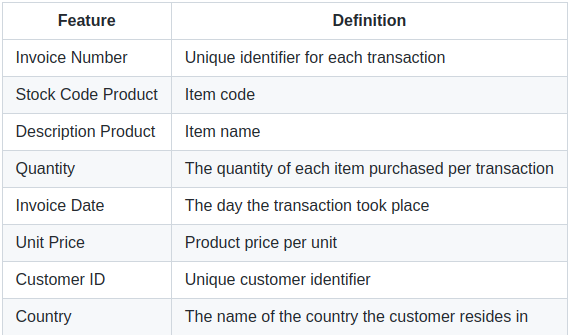

In [203]:
Image('../image/features_description.png')

### 1.2 Data Types

In [204]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.3 Check NA

In [1]:
df1.isna().sum()

NameError: name 'df1' is not defined

In [210]:
df1['customer_id'].drop_duplicates().dropna()

0         17850.0
9         13047.0
26        12583.0
46        13748.0
65        15100.0
           ...   
536969    13436.0
537255    15520.0
538064    13298.0
538812    14569.0
541768    12713.0
Name: customer_id, Length: 4372, dtype: float64

### 1.4 Fillout NA

In [10]:
# Para avançar com o projeto de forma rápida, vamos retirar os registros com valores faltantes. 
# Posteriormente serão analisadas outras possibilidades de tratar esses dados.

# df1 = df1.dropna(subset=['description', 'customer_id'])
# print('Removed data: {:.0%}'.format( 1-(df1.shape[0] / df_raw.shape[0])))
# print(f'New number of rows: {df1.shape[0]}')

In [11]:
# Analise detalhada do Na

df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [12]:
# Tentativa 1: verificar se algum invoice_no está nos 2 datasets (df_missing e df_not_missing)
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
missing_invoice[0:10]

['536414',
 '536544',
 '536545',
 '536546',
 '536547',
 '536549',
 '536550',
 '536552',
 '536553',
 '536554']

In [13]:
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), : ]

# Nenhum resultado bateu...

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [14]:
# Tentativa 2: criar um id para os valores faltantes e assim não descartar as informações registradas

# create reference

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)


# Merge with original dataframe
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# **Coalesce - função legal para aprender 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis=1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,United Kingdom,17850.0


In [15]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.5 Change Types

In [16]:
df1['customer_id'] = df1['customer_id'].astype(int)

In [17]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])
df1['invoice_date'] = df1['invoice_date'].dt.strftime('%Y-%m-%d')

In [18]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


In [19]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.6 Descriptive Statistics

#### 1.6.0  Datasets

In [20]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])


#### 1.6.1 Nummerical Attributes

In [21]:
numerical_metrics(num_attributes)

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


<font color = 'red'> Attention Points </font>

1. Negative Quantity
2. Unit price equal zero

#### 1.6.2 Categorical Attributes

In [22]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


##### Invoice No

In [23]:
# The invoice_no should be a number
# df1['invoice_no'].astype(int) --> dá erro pois alguns registros possuem letras no código

# Quantidade de registros com letras
df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

df_letter_invoice

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2010-12-01,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,United Kingdom,17548
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09,0.83,United Kingdom,14397
541541,C581499,M,Manual,-1,2011-12-09,224.69,United Kingdom,15498
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09,10.95,United Kingdom,15311
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09,1.25,United Kingdom,17315


In [24]:
print(f'Total invoice_no with letter: {len(df_letter_invoice)}')
print('Total invoice_no with letter and negative quantity value: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity']<0])))

Total invoice_no with letter: 9291
Total invoice_no with letter and negative quantity value: 9288


##### Stock Code

In [25]:
# The stock_code should be a number
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2010-12-01,18.00,France,12583
141,C536379,D,Discount,-1,2010-12-01,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2010-12-01,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2010-12-01,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01,569.77,United Kingdom,19001
...,...,...,...,...,...,...,...,...
541540,581498,DOT,DOTCOM POSTAGE,1,2011-12-09,1714.17,United Kingdom,22709
541541,C581499,M,Manual,-1,2011-12-09,224.69,United Kingdom,15498
541730,581570,POST,POSTAGE,1,2011-12-09,18.00,Germany,12662
541767,581574,POST,POSTAGE,2,2011-12-09,18.00,Germany,12526


In [26]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# task: remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

##### Description

In [27]:
# Nesse ciclo a Description não parece ser importante para a melhoria do algoritmo

# Task: delete description

##### Country

In [28]:
len(df1['country'].unique())

38

In [29]:
df1['country'].value_counts(normalize = True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [30]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2. Data Filtering 

In [31]:
df2 = df1.copy()

In [32]:
# ==== Bad Users ====

df2 = df2[~df2['customer_id'].isin([16446])]

# ==== Cat Attributes ====

# Stock Code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# Description
df2 = df2.drop(columns = 'description', axis = 1)

# Country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]


# ==== Num Attributes ====

# Unit Price > 0.04 
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Quantity
df_returns = df2.loc[df2['quantity']<0, :]
df_purchases = df2.loc[df2['quantity']>0, :]


# 3. Feature Engineering

### 3.1 Gross Revenue

In [33]:
df3 = df2.copy()

In [34]:
# Data Reference
df_ref = df3.drop (['invoice_no', 'stock_code',
                    'quantity', 'invoice_date', 'unit_price',
                    'country'], axis=1).drop_duplicates(ignore_index=True)

In [35]:
# Monetary (Gross Revenue)
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']
df_monetary = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge (df_ref, df_monetary, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.2 Recency - Day from last purchase

In [36]:
# Recency
df_recency = df_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.3 Quantity of purchase

In [37]:
df_count = (df_purchases[['customer_id', 'invoice_no']].drop_duplicates()
                                                       .groupby('customer_id')
                                                       .count()
                                                       .reset_index()
                                                       .rename(columns={'invoice_no':'qtd_invoices'}))

df_ref = pd.merge(df_ref, df_count, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
dtype: int64

### 3.4 Quantity of items purchased

In [38]:
df_prod = (df_purchases[['customer_id', 'quantity']].groupby('customer_id')
                                                    .sum()
                                                    .reset_index()
                                                    .rename(columns={'quantity':'qtd_items'}))

df_ref = pd.merge(df_ref, df_prod, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
qtd_items        91
dtype: int64

### 3.4 Quantity of products purchased

In [39]:
df_prod = (df_purchases[['customer_id', 'stock_code']].groupby('customer_id')
                                                      .count()
                                                      .reset_index()
                                                      .rename(columns={'stock_code':'qtd_products'}))

df_ref = pd.merge(df_ref, df_prod, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
qtd_items        91
qtd_products     91
dtype: int64

### 3.4 Average Ticket Value

In [40]:
# Avg Ticket
df_avg_ticket = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
qtd_items        91
qtd_products     91
avg_ticket       91
dtype: int64

### 3.5 Average Recency Days


In [41]:
df_aux = df_purchases[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])

df_aux['previous_customer'] = df_aux['customer_id'].shift()
df_aux['previous_date']     = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['previous_customer'] else np.nan, axis=1)
df_aux = df_aux.drop(['invoice_date', 'previous_customer', 'previous_date'], axis=1).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on = 'customer_id', how = 'left')
df_ref.isna().sum()


customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    3013
dtype: int64

### 3.6 Frequency Purchase

In [42]:
df_aux = (df_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                     .groupby('customer_id')
                                                                     .agg(max_    = ('invoice_date', 'max'),
                                                                          min_    = ('invoice_date', 'min'),
                                                                          days_   = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                          buy_    = ('invoice_no', 'count') ) ).reset_index()

df_aux.head()

,customer_id,max_,min_,days_,buy_
0,12346,2011-01-18,2011-01-18,1,1
1,12347,2011-12-07,2010-12-07,366,7
2,12348,2011-09-25,2010-12-16,284,4
3,12349,2011-11-21,2011-11-21,1,1
4,12350,2011-02-02,2011-02-02,1,1


In [43]:
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)
df_aux.head(10)

,customer_id,max_,min_,days_,buy_,frequency
0,12346,2011-01-18,2011-01-18,1,1,1.000000
1,12347,2011-12-07,2010-12-07,366,7,0.019126
2,12348,2011-09-25,2010-12-16,284,4,0.014085
3,12349,2011-11-21,2011-11-21,1,1,1.000000
4,12350,2011-02-02,2011-02-02,1,1,1.000000
5,12352,2011-11-03,2011-02-16,261,7,0.026820
6,12353,2011-05-19,2011-05-19,1,1,1.000000
7,12354,2011-04-21,2011-04-21,1,1,1.000000
8,12355,2011-05-09,2011-05-09,1,1,1.000000
9,12356,2011-11-17,2011-01-18,304,3,0.009868


In [44]:
# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    3013
frequency             91
dtype: int64

### 3.7 Returns

In [45]:
df_returns.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
154,C536383,35004C,-1,2010-12-01,4.65,United Kingdom,15311
235,C536391,22556,-12,2010-12-01,1.65,United Kingdom,17548
236,C536391,21984,-24,2010-12-01,0.29,United Kingdom,17548
237,C536391,21983,-24,2010-12-01,0.29,United Kingdom,17548
238,C536391,21980,-24,2010-12-01,0.29,United Kingdom,17548


In [46]:
# Return Number
df_returns = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity' : 'returns'})
df_returns['returns'] = df_returns['returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how = 'left', on='customer_id')

df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    3013
frequency             91
returns                0
dtype: int64

### 3.8 Basket Size - quantidade de itens por cesta

In [47]:
df_aux = (df_purchases.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                       .agg(
                                                                          n_purchases = ('invoice_no', 'nunique'),
                                                                          n_products = ('quantity', 'sum') ).reset_index() )   

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

df_aux.head()

,customer_id,n_purchases,n_products,avg_basket_size
0,12346,1,74215,74215.000000
1,12347,7,2458,351.142857
2,12348,4,2332,583.000000
3,12349,1,630,630.000000
4,12350,1,196,196.000000


In [48]:
# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on = 'customer_id', how = 'left')
df_ref.isna().sum()


customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    3013
frequency             91
returns                0
avg_basket_size       91
dtype: int64

### 3.9 Unique Basket Size - quantidade de produtos distintos por compra

In [49]:
df_aux = (df_purchases.loc[:,['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                         .agg(
                                                                          n_purchases = ('invoice_no', 'nunique'),
                                                                          n_products = ('stock_code', 'count') ).reset_index() )   

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']
df_aux.head()

,customer_id,n_purchases,n_products,avg_unique_basket_size
0,12346,1,1,1.00
1,12347,7,182,26.00
2,12348,4,27,6.75
3,12349,1,72,72.00
4,12350,1,16,16.00


In [50]:
# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtd_invoices                91
qtd_items                   91
qtd_products                91
avg_ticket                  91
avg_recency_days          3013
frequency                   91
returns                      0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [51]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,1.000000,17.000000,40.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,52.833333,0.028302,35.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,26.500000,0.040323,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,20.000000,0.073171,22.0,26.666667,1.000000


# 4. Exploratory Data Analysis

### 4.1 Univariate Analysis

In [52]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtd_invoices              0
qtd_items                 0
qtd_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
returns                   0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

In [211]:
print(df_ref.shape)
print(df4.shape)


(5786, 12)
(2773, 12)


In [53]:
#profile = ProfileReport(df4)
#profile.to_file('output.html')

#### 4.1.1 Gross Revenue

In [54]:
df4.sort_values('gross_revenue', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,8.022727,0.203390,288.0,2733.944444,28.611111
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,7.183333
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,13.807692,0.127778,952.0,1521.586957,7.326087
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.861538,0.533512,3332.0,403.331658,28.507538
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,22.357143,0.063694,427.0,3868.650000,35.650000
190,14156,117379.63,9.0,55.0,57885.0,1400.0,83.842593,8.619048,0.151515,859.0,1052.454545,25.454545
15,17511,91062.38,2.0,31.0,64549.0,963.0,94.561142,13.740741,0.083333,1535.0,2082.225806,31.064516
12,16029,72882.09,38.0,62.0,40207.0,241.0,302.415311,9.054054,0.184524,8004.0,648.500000,3.887097
955,16684,66653.56,4.0,28.0,50255.0,277.0,240.626570,23.600000,0.078873,864.0,1794.821429,9.892857
36,13694,65039.62,3.0,50.0,63312.0,568.0,114.506373,10.882353,0.134771,1504.0,1266.240000,11.360000


In [55]:
# Verificando customer 14646 (maior gross_revenue)

print('Gross Revenue Total: {}'.format(np.sum(df3.loc[df3['customer_id'] == 14646, 'quantity'] * df3.loc[df3['customer_id'] == 14646, 'unit_price'])))
print('Quantity Total: {}'.format(df3.loc[df3['customer_id'] == 14646, 'quantity'].sum()))


Gross Revenue Total: 278778.02
Quantity Total: 196556


<AxesSubplot:xlabel='gross_revenue', ylabel='Count'>

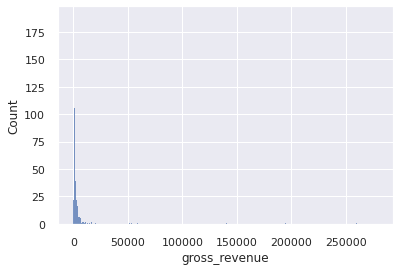

In [56]:
sns.set(rc={'figure.figsize':(20,8)})
sns.histplot(df4['gross_revenue'], binwidth=100)

#### 4.1.2 Avg Ticket

In [57]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size


In [58]:
df1[df1['customer_id'] == 16446]

# Remover esse user no data filtering

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18,1.65,United Kingdom,16446
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18,1.25,United Kingdom,16446
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,United Kingdom,16446
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09,2.08,United Kingdom,16446


#### 4.1.3 Qtde Invoice

In [59]:
df4[df4['qtd_items'] == 196844]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,8.022727,0.20339,288.0,2733.944444,28.611111


#### 4.1.4 Frequency

In [60]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,1.0,17.0,40.0,50.970588,8.735294


In [61]:
df3[df3['customer_id'] == 17850].sort_values('quantity', ascending = False).head(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
4528,536790,84406B,12,2010-12-02,2.75,United Kingdom,17850
4162,536750,71053,12,2010-12-02,3.39,United Kingdom,17850
3808,536685,85123A,12,2010-12-02,2.55,United Kingdom,17850
4526,536790,85123A,12,2010-12-02,2.95,United Kingdom,17850
4527,536790,71053,12,2010-12-02,3.39,United Kingdom,17850
3809,536685,71053,12,2010-12-02,3.39,United Kingdom,17850
4531,536790,37370,12,2010-12-02,1.06,United Kingdom,17850
4532,536790,21071,12,2010-12-02,1.06,United Kingdom,17850
4533,536790,21068,12,2010-12-02,1.06,United Kingdom,17850
290,536396,82494L,12,2010-12-01,2.55,United Kingdom,17850


### 4.2 Bivariate Analysis

In [63]:
# cols = ['customer_id']
# df42 = df4.drop(cols, axis = 1)

# plt.figure(figsize = (25,12))
# sns.pairplot(df42)

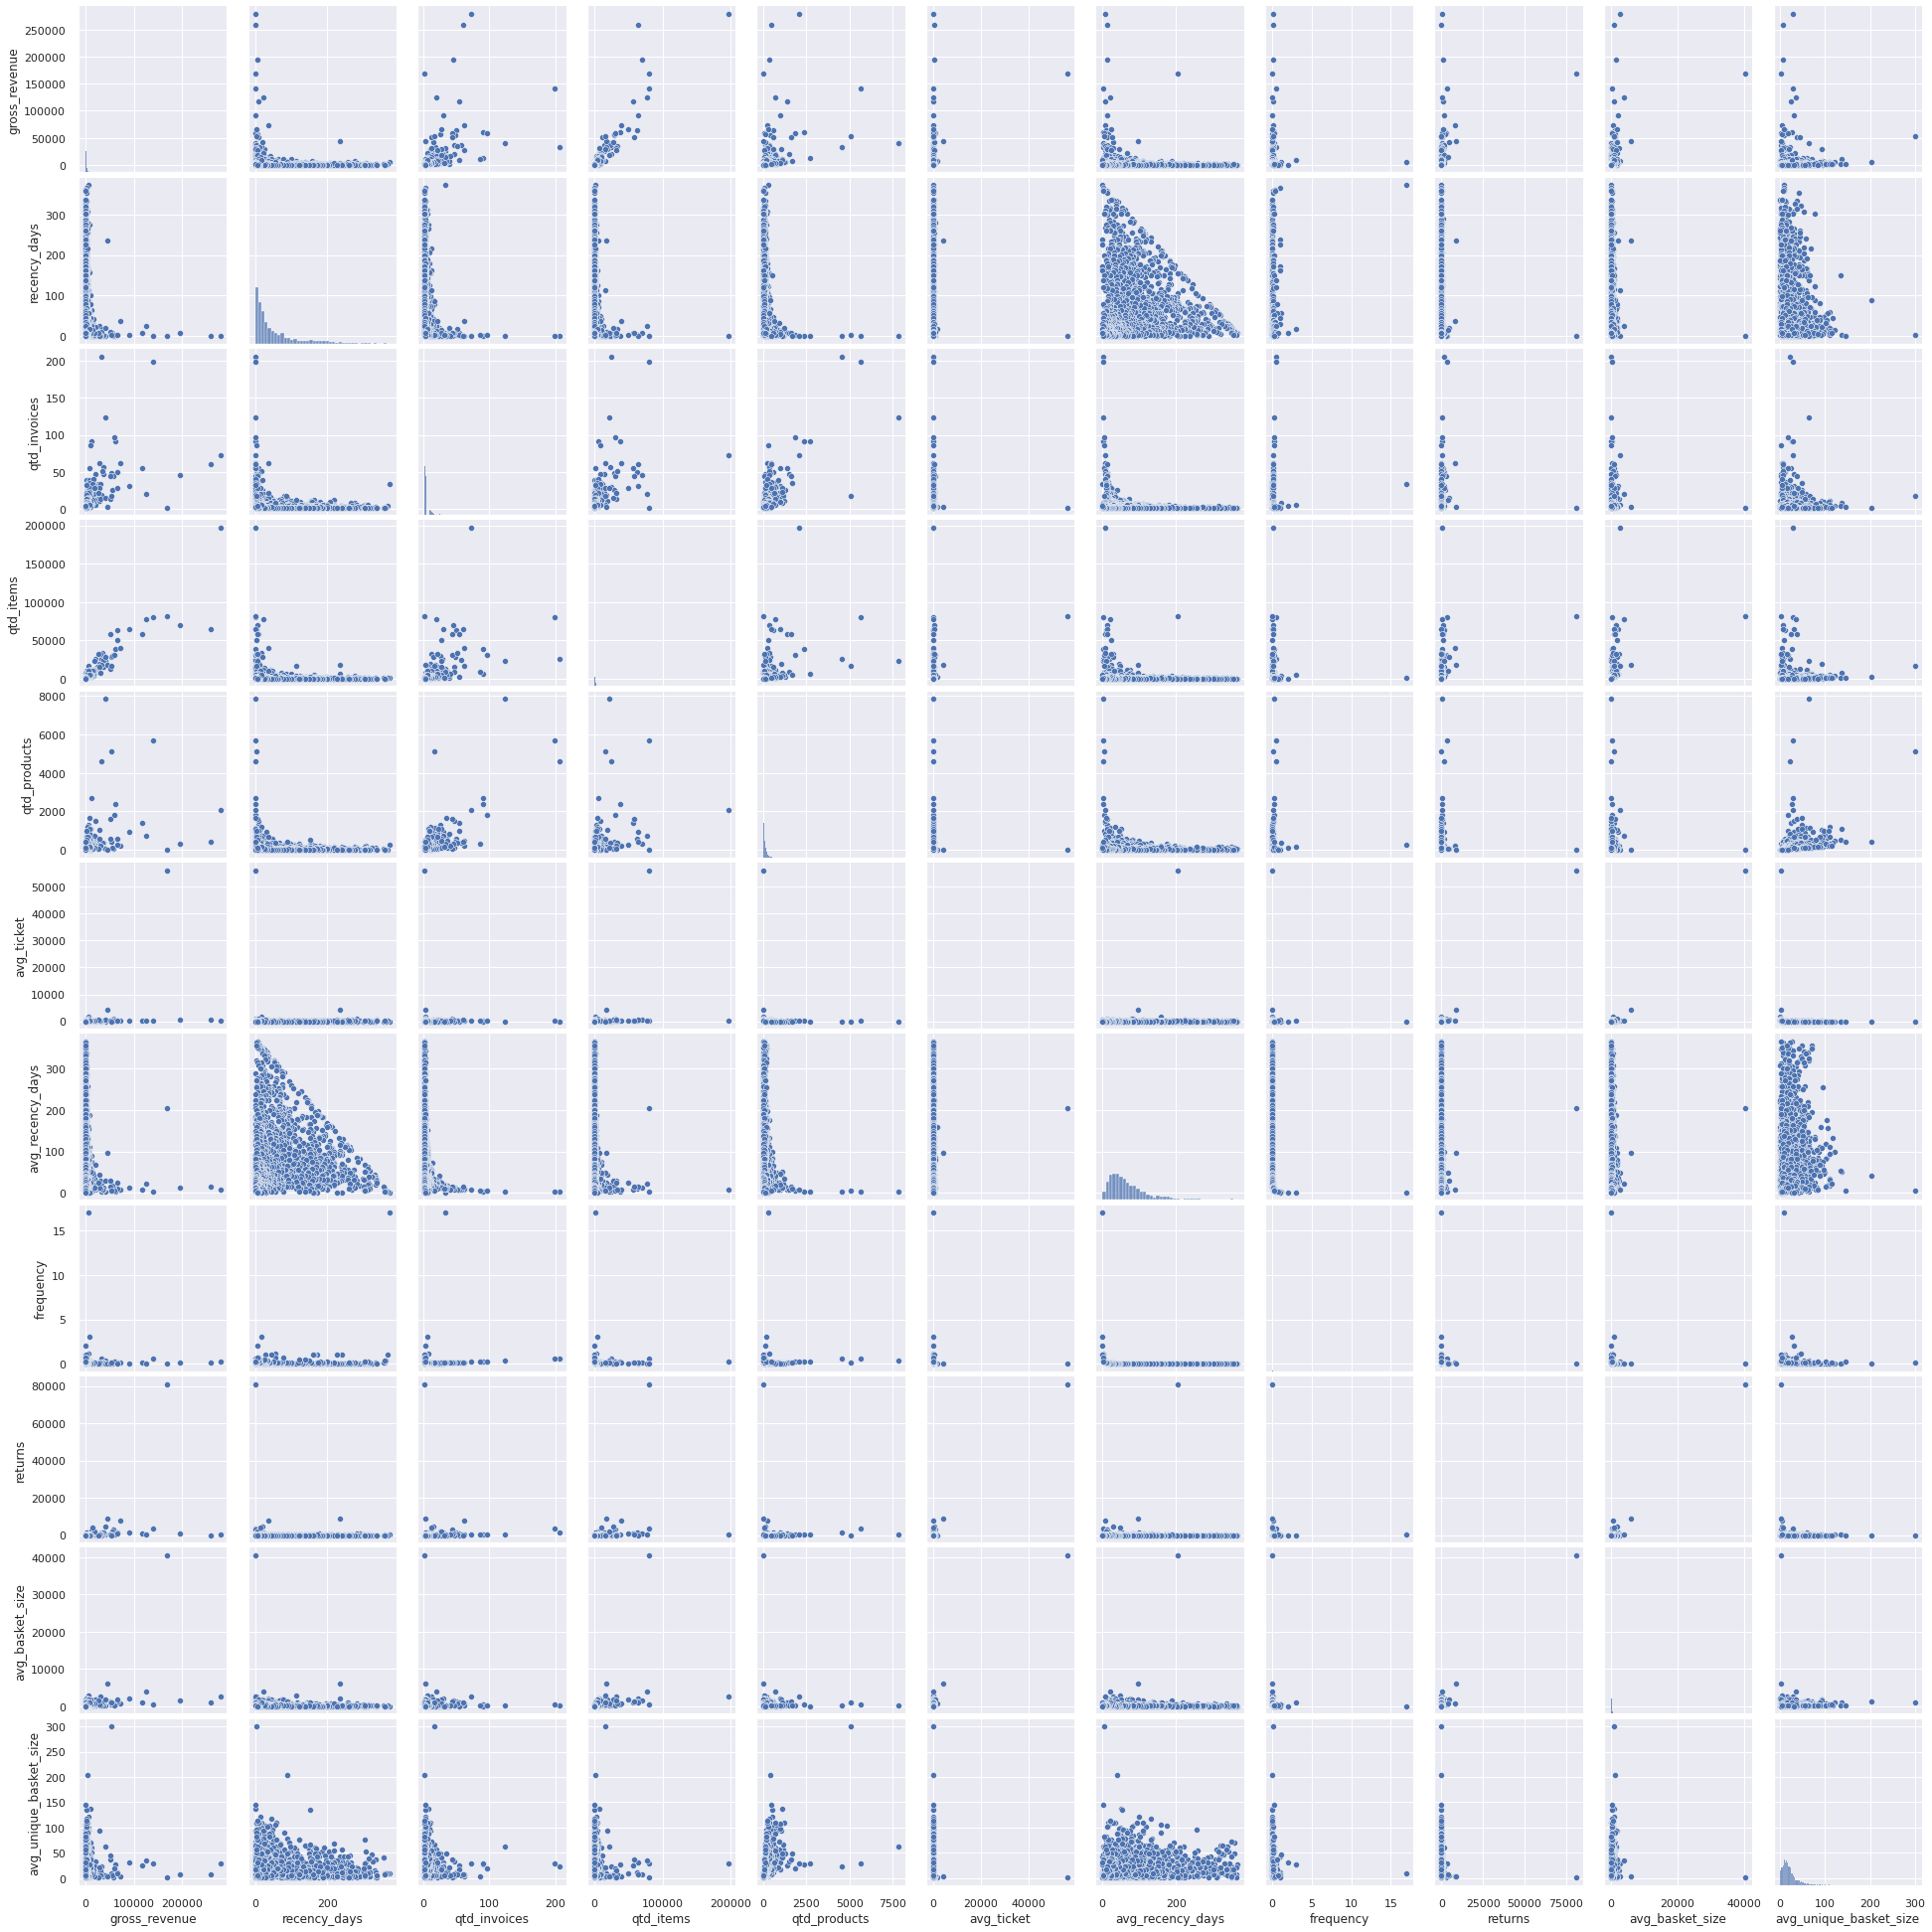

In [64]:
Image('../image/bivariate_analysis.png')

# Frequency and average ticket has low variance

### 4.3 Data Space Study 

#### 4.3.0 Data Preparation

In [65]:
# df43 = df4.drop(columns = ['customer_id'], axis=1).copy()

# Selected Dataset
cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtd_products', 'frequency', 'returns']
df43 = df4[cols_select].copy()
df43.head()

,customer_id,gross_revenue,recency_days,qtd_products,frequency,returns
0,17850,5391.21,372.0,297.0,17.000000,40.0
1,13047,3232.59,56.0,171.0,0.028302,35.0
2,12583,6705.38,2.0,232.0,0.040323,50.0
3,13748,948.25,95.0,28.0,0.017921,0.0
4,15100,876.00,333.0,3.0,0.073171,22.0


In [66]:
mm = pp.MinMaxScaler()

df43['gross_revenue']               = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']                = mm.fit_transform(df43[['recency_days']])
# df43['qtd_invoices']                = mm.fit_transform(df43[['qtd_invoices']])
# df43['qtd_items']                   = mm.fit_transform(df43[['qtd_items']])
df43['qtd_products']                = mm.fit_transform(df43[['qtd_products']])
# df43['avg_ticket']                  = mm.fit_transform(df43[['avg_ticket']])
# df43['avg_recency_days']            = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency']                   = mm.fit_transform(df43[['frequency']])
df43['returns']                     = mm.fit_transform(df43[['returns']])
# df43['avg_basket_size']             = mm.fit_transform(df43[['avg_basket_size']])
# df43['avg_unique_basket_size']      = mm.fit_transform(df43[['avg_unique_basket_size']])

In [67]:
X = df43.copy()
X.head()

,customer_id,gross_revenue,recency_days,qtd_products,frequency,returns
0,17850,0.019185,1.000000,0.037647,1.000000,0.004438
1,13047,0.011451,0.150538,0.021567,0.001345,0.003883
2,12583,0.023894,0.005376,0.029352,0.002052,0.005547
3,13748,0.003267,0.255376,0.003318,0.000734,0.000000
4,15100,0.003008,0.895161,0.000128,0.003985,0.002441


In [193]:
X.shape

(2773, 2)

#### 4.3.1 PCA

In [68]:
X.shape[1]

6

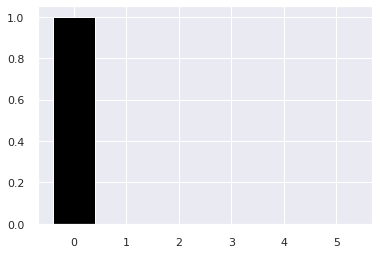

In [69]:
pca = dd.PCA(n_components = X.shape[1])
principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

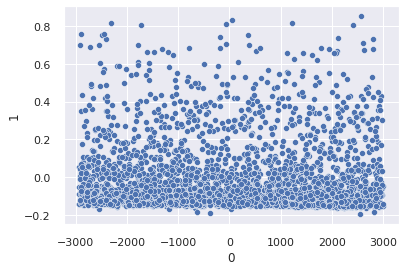

In [70]:
sns.scatterplot(x=0, y=1, data = df_pca)

# O espaço gerado pelo PCA continuou bastante aglomerado, não se mostrando eficaz no processo de clusterização

#### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

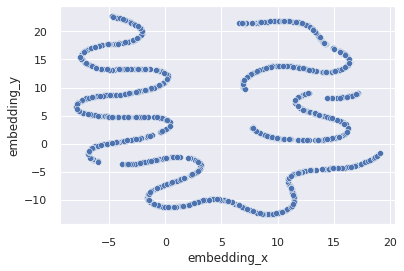

In [71]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform (X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plto UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_pca)

#### 4.3.3 t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

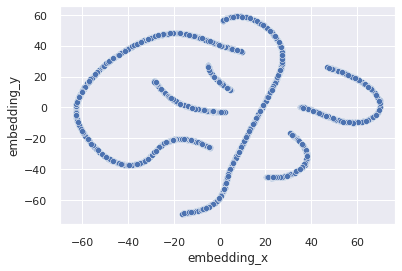

In [72]:
reducer = mn.TSNE(n_components = 2,
               n_jobs = -1,
               random_state=42)

embedding = reducer.fit_transform (X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plto UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_pca)

#### 4.3.4 Tree-Based Embedding

- Com o objetivo de gerar um novo espaço através da distribuição dos dados feita pela decision tree
- A ideia é transformar o problema não supervisionado de clusterização para um supervisionado de regressão usando o Random Forest.
- Para isso, vamos definir a feature gross_revenue como a variável resposta.


In [73]:
# Training Dataset
X = df43.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df43['gross_revenue']

# Model Definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)  # o n_estimators é o número de arvores (decision tree) geradas pelo algoritmo

# Model Training
rf_model.fit(X, y)                                                      # modelo trainado com o X para prever y (é construída a estrutura da "arvore")

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))                               # O "apply" é um método da classe RandomForestRegressor que, aplicando o conjunto 
                                                                        # de treino na estrutura da arvore gerada, vai mostrar em que folha cada registro 
                                                                        # vai ficar para cada arvore gerada (100 arvores nesse caso).
                                                                        # Esse conjunto de dados gera um novo espaço com 100 dimensões.

In [74]:
df_leaf.head()

# O valor da coordenada (0,0) de 2608 seria a posição da folha no espaço

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3416,3174,3339,3489,3049,3331,3248,3332,3512,3229,...,3139,3345,3418,3423,3295,3409,3294,3227,3283,3181
1,2954,3069,2841,2891,2816,3231,3104,3177,2826,3036,...,2727,3219,2793,3036,3123,3315,2969,3019,2504,3049
2,3073,3192,3217,3340,2890,3346,3139,3242,3409,3164,...,3129,3245,3337,3010,3256,3342,2730,3164,3381,3159
3,696,991,1164,693,918,503,862,298,660,564,...,966,297,724,972,300,607,984,1162,1200,1159
4,539,536,575,1095,41,611,1670,716,858,265,...,357,758,1071,526,642,1041,1904,1663,504,543


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

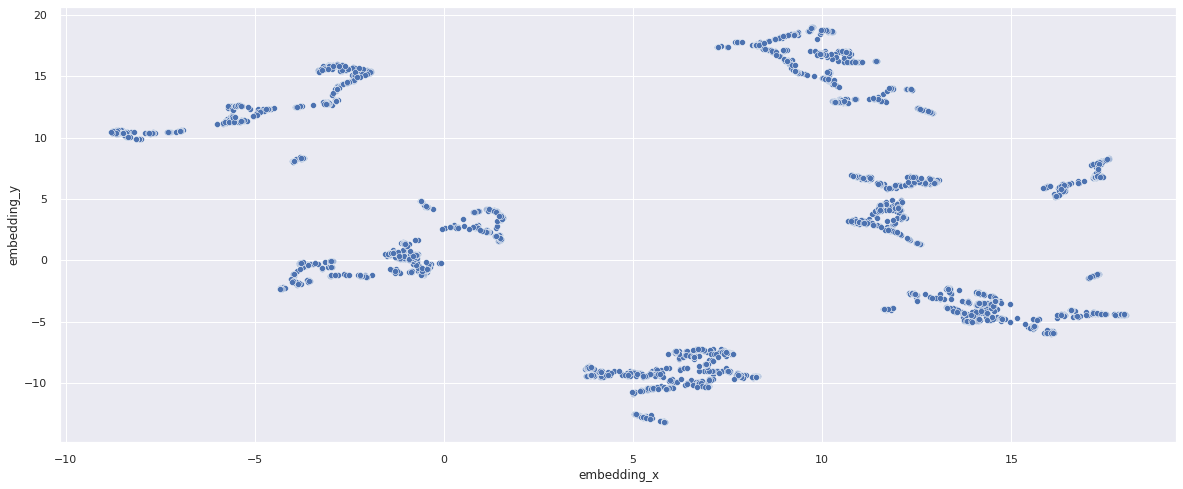

In [75]:
# Reduzer Dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform (df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plto UMAP
sns.set(rc={'figure.figsize':(20,8)})
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_tree)

# 5. Data Preparation

In [76]:
# df5 = df4.copy()
# df5_aux = df4.copy()

df5 = df_tree.copy()   # Clusterig with Tree-Based Embedding Data Frame 

In [77]:
# mm = pp.MinMaxScaler()
# ss = pp.StandardScaler()
# rs = pp.RobustScaler()

# df5['gross_revenue']               = mm.fit_transform(df5[['gross_revenue']])
# df5['recency_days']                = mm.fit_transform(df5[['recency_days']])
# # df5['qtd_invoices']                = mm.fit_transform(df5[['qtd_invoices']])
# # df5['qtd_items']                   = mm.fit_transform(df5[['qtd_items']])
# df5['qtd_products']                = mm.fit_transform(df5[['qtd_products']])
# # df5['avg_ticket']                  = mm.fit_transform(df5[['avg_ticket']])
# # df5['avg_recency_days']            = mm.fit_transform(df5[['avg_recency_days']])
# df5['frequency']                   = mm.fit_transform(df5[['frequency']])
# df5['returns']                     = mm.fit_transform(df5[['returns']])
# # df5['avg_basket_size']             = mm.fit_transform(df5[['avg_basket_size']])
# # df5['avg_unique_basket_size']      = mm.fit_transform(df5[['avg_unique_basket_size']])

# variable = 'avg_recency_days'

#### 5.1 Standart Test

In [78]:
# # Dados AS IS
# print('Min:{} - Max:{}'.format(df5_aux[variable].min(), df5_aux[variable].max()))

# sns.distplot(df5_aux[variable])

In [79]:
# # Dados Normalizados / Reescalados
# print('Min:{} - Max:{}'.format(df5[variable].min(), df5[variable].max()))
# sns.distplot(df5[variable])

In [80]:
# # Outliers
# sns.boxplot(df5[variable]);

# 6. Feature Selection

### 6.1 Assumption

Problemas de clusterização não possuem técnicas de feature selection bem definidas. Normalmente essa seleção é feita a partir da analise do negócio.

Nesse caso, seguirei a seguinte linha de raciocínio:
1) Retirar features que são cálculos de médias, pois a descrição do cluster será feita a partir de médias, ou seja, seria calculado a média da média.
2) No gráfico de pair plot, analisar features mais relacionadas. No caso, temos qtd_invoices, qtd_items, qtd_products que podemos escolher apenas uma das 3

### 6.2 Selection

In [81]:
# cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtd_products', 'frequency', 'returns']

In [82]:
# df6 = df5[cols_select].copy()
df6 = df_tree.copy()

# 7. Hyperparameter Fine-Tunning

### 7.0 Dataset

In [83]:
# X = df6.drop(columns = ['customer_id'])
X = df_tree.copy()
X.head()


,embedding_x,embedding_y
0,9.206601,15.958380
1,17.325029,7.942975
2,9.537803,15.157524
3,1.426457,3.173507
4,-0.446303,4.363061


In [84]:
# clusters = [2, 3, 4, 5, 6, 7]

clusters = np.arange(2, 31, 1)

clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

### 7.1 K-Means

In [85]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(init='random',
                            n_clusters=k,
                            n_init=10,
                            max_iter=300,
                            random_state=42)

    # model training
    kmeans_model.fit(X)

    # clustering
    labels = kmeans_model.predict(X) 

    # model performance (SS)
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

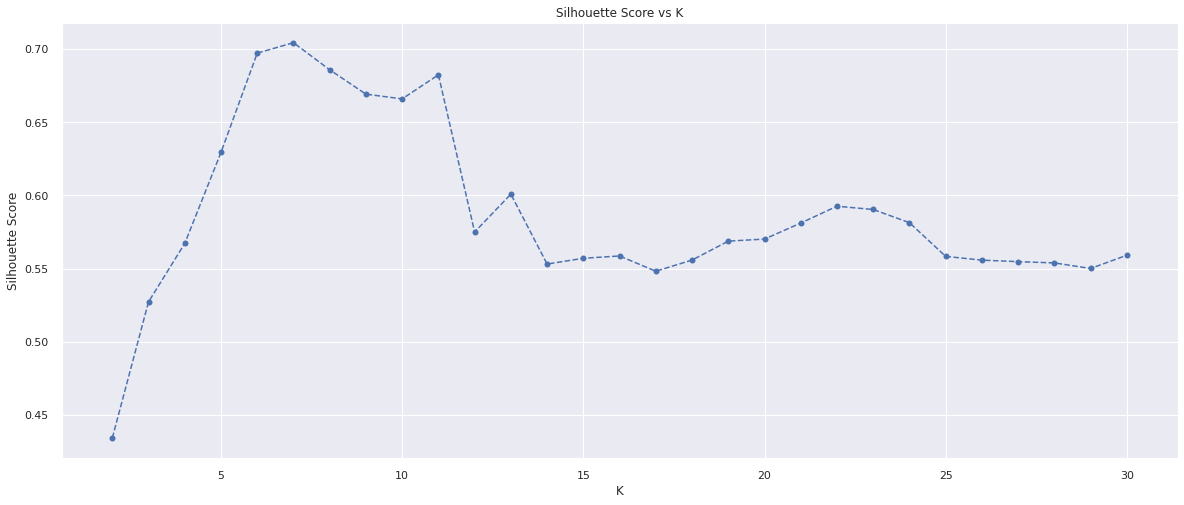

In [86]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs K');

### 7.2 GMM

In [87]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

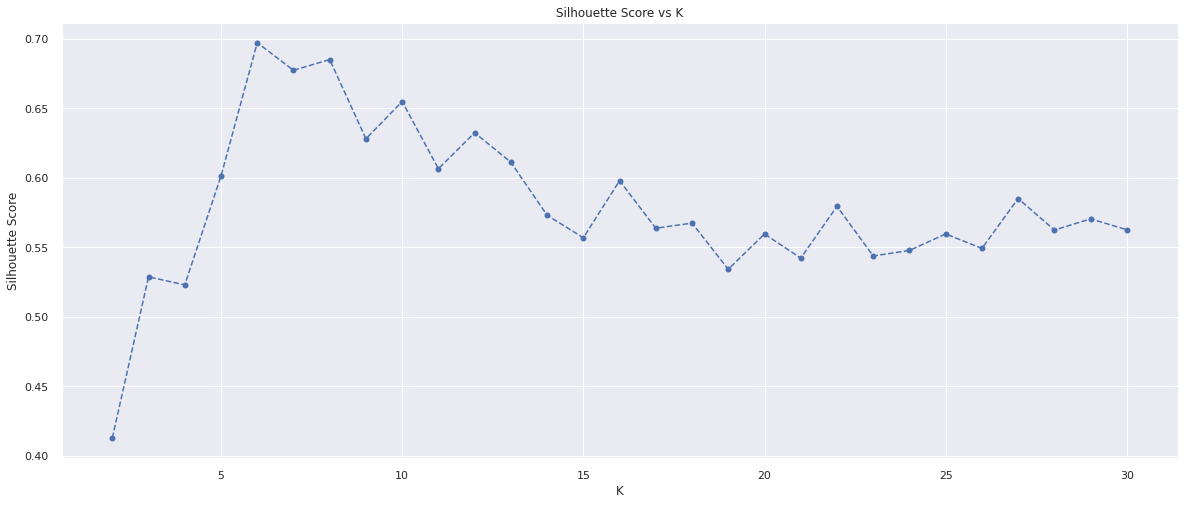

In [88]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs K');

### 7.3 Hierarchical Clustering

In [89]:
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

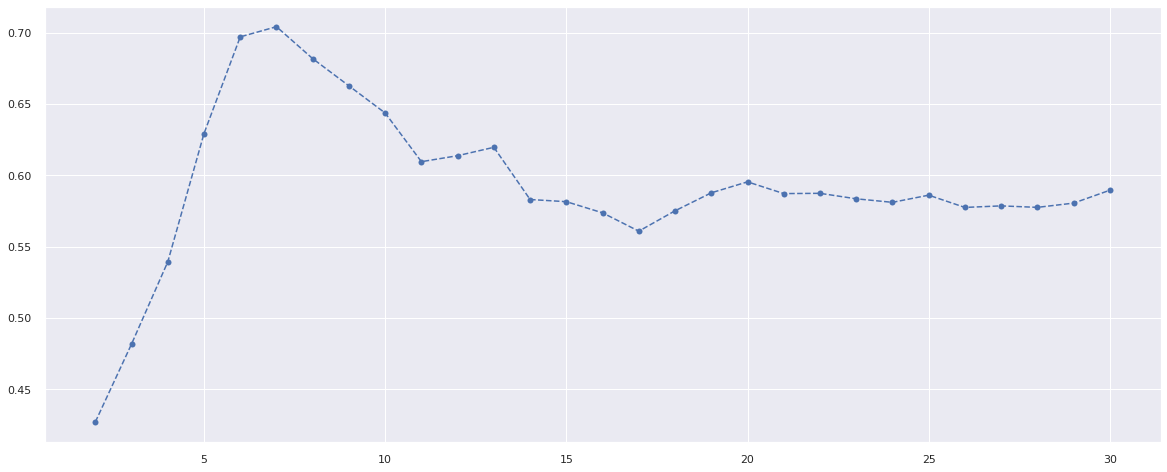

In [90]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')

In [91]:
# hc.dendrogram(
#     hc_model,
#     leaf_rotation=90,
#     leaf_font_size=8
# )

# plt.plot()

In [92]:
# hc.dendrogram(
#     hc_model,
#     truncate_mode='lastp',
#     p=12,
#     leaf_rotation=90,
#     leaf_font_size=8,
#     show_contracted=True
# )

# plt.show()

### 7.4 DBSCAN

In [93]:
eps=0.013
min_samples=20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and predict
labels = dbscan_model.fit_predict(X)

# model performance
sil = m.silhouette_score(X, labels, metric='euclidean')
print('Silhouette Score: {}'.format(sil))
print('Number od Clusters: {}'.format(len(np.unique(labels))))
print(np.unique(labels))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
dbscan_list = [0.545137, 0.414280, 0.000000, 0.000000, 0.242608, 0.310148]

### 7.5 Results

In [94]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [95]:
df_results.style.highlight_max(color = 'blue', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
KMeans,0.434257,0.527310,0.567226,0.629435,0.697246,0.704385,0.685851,0.669213,0.665997,0.682415,0.575032,0.600883,0.553130,0.557088,0.558660,0.548228,0.555852,0.568783,0.570205,0.581142,0.592649,0.590408,0.581399,0.558376,0.555801,0.554770,0.553904,0.550117,0.559150
GMM,0.412880,0.528801,0.523042,0.601354,0.697246,0.677393,0.685100,0.628114,0.654920,0.606605,0.632501,0.611247,0.573109,0.556945,0.597973,0.563782,0.567479,0.534279,0.559659,0.542273,0.579541,0.543842,0.547795,0.559677,0.549278,0.585161,0.562479,0.570496,0.562712
HC,0.427036,0.481754,0.539387,0.629435,0.697246,0.704385,0.681964,0.662878,0.643822,0.609683,0.613879,0.619766,0.583140,0.581624,0.573789,0.560936,0.575215,0.587834,0.595531,0.587300,0.587480,0.583639,0.581164,0.586189,0.577589,0.578676,0.577636,0.580616,0.589657


### 7.6 Silhouette Analysis

For K = 2. Silhouette Score:0.42703619599342346
For K = 3. Silhouette Score:0.4817543029785156
For K = 4. Silhouette Score:0.539386510848999
For K = 5. Silhouette Score:0.6294353604316711
For K = 6. Silhouette Score:0.6972455978393555
For K = 7. Silhouette Score:0.7043851017951965


IndexError: index 3 is out of bounds for axis 0 with size 3

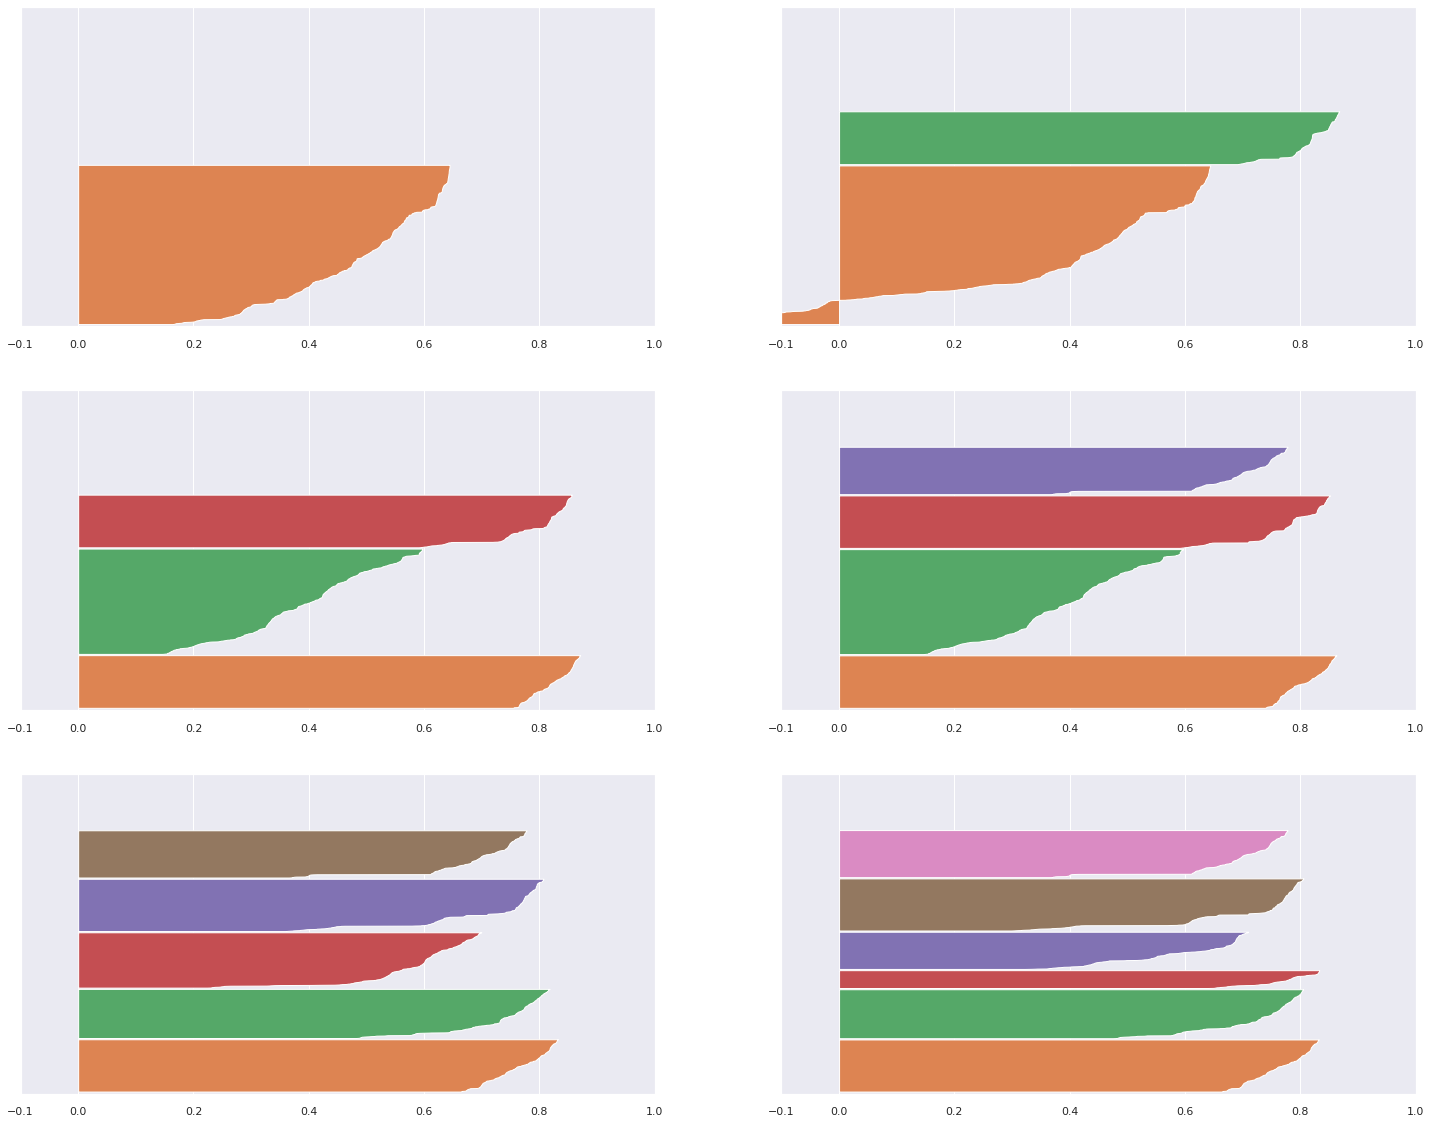

In [96]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q, mod = divmod(k,2)

    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10])


    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # model performance
    ss = m.silhouette_score(X, labels, metric='euclidean')
    print('For K = {}. Silhouette Score:{}'.format(k, ss))


    samples_silhouette_values = m.silhouette_samples(X, labels)

    y_lower = 10
    for i in range (k):
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels==i]

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap('Spectral')
        color = cmap(i/k)

        # sort values
        ith_samples_silhouette_values.sort()

        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)

        y_lower = y_upper + 10
        

    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])


# 8. Machine Learning Modelling

### 8.1 K-Means

In [168]:
# model definition
k=7
kmeans = c.KMeans(init='random',
                  n_clusters=k,
                  n_init=10,
                  max_iter=300,
                  random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 GMM

In [169]:
# k=5
# # model definition
# gmm_model = mx.GaussianMixture(n_components=k)

# # model training
# gmm_model.fit(X)

# # model predict
# labels = gmm_model.predict(X)

### 8.2 Cluster Validation

In [170]:
# WSS
print(f'WSS Value:{kmeans.inertia_}')

# SS
print('SS Value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Value:15760.05859375
SS Value: 0.7043851017951965


# 9. Evaluation - Cluster Analysis

### 9.1 Visualization Inspection

In [171]:
df9 = X.copy()
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,9.206601,15.958380,5
1,17.325029,7.942975,0
2,9.537803,15.157524,5
3,1.426457,3.173507,2
4,-0.446303,4.363061,2


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

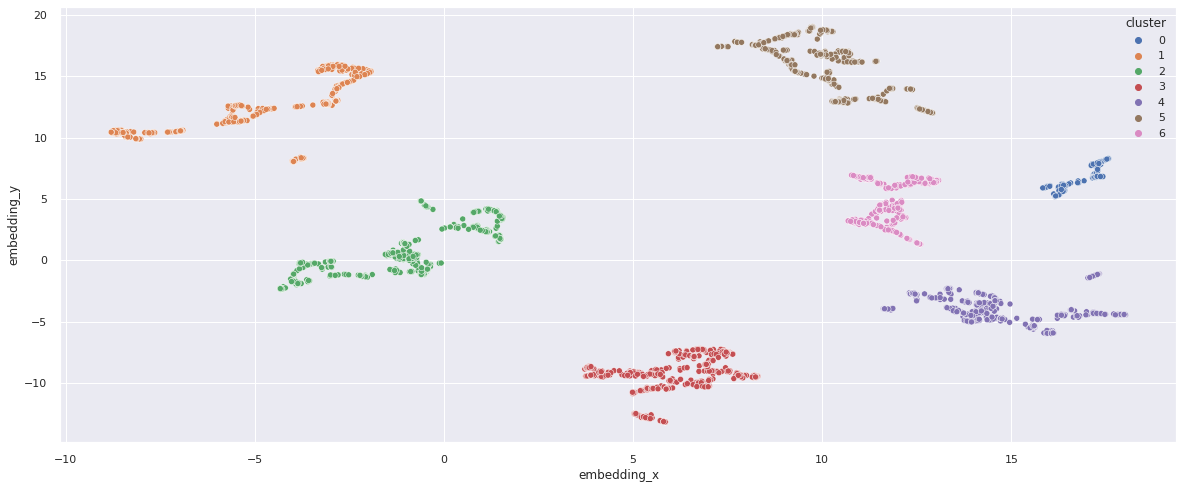

In [172]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

In [173]:
# df9 = df4.copy()
# df9['cluster'] = labels
# df9.head()

In [174]:
# # Silhouette Viz:
# visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
# visualizer.fit(X)
# visualizer.finalize()

In [175]:
# 2D Plot (Pair Plot)
# df_viz = df9.drop(columns='customer_id', axis=1)
# sns.pairplot(df_viz, hue='cluster')

In [176]:
# UMAP (mais rápido para grandes quantidades de dados) / t-SNE (mais preciso, porém mais lento): 
    # abordagem por Manifold (topologia) - projeção de altas dimensões em 3D ou 2D sem perder suas características principais

# reducer = umap.UMAP(n_neighbors=40, random_state=42)
# embedding = reducer.fit_transform (X)

# # embedding
# df_viz['embedding_x'] = embedding[:, 0]
# df_viz['embedding_y'] = embedding[:, 1]

# # plto UMAP
# sns.scatterplot( x='embedding_x',
#                  y='embedding_y',
#                  hue='cluster',
#                  palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
#                  data = df_viz)

### 9.2 Cluster Profile

In [177]:
df92 = df4[cols_select].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtd_products,frequency,returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,5
1,13047,3232.59,56.0,171.0,0.028302,35.0,0
2,12583,6705.38,2.0,232.0,0.040323,50.0,5
3,13748,948.25,95.0,28.0,0.017921,0.0,2
4,15100,876.00,333.0,3.0,0.073171,22.0,2


In [178]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on = 'cluster')

# Avg recency
df_avg_recency = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

# Avg qtd_products
df_avg_qtd_products = df92[['qtd_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_qtd_products, how='inner', on='cluster')

# Avg frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Avg returns
df_returns = df92[['returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on='cluster')


df_cluster.sort_values('gross_revenue', ascending=False)


,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtd_products,frequency,returns
5,5,466,16.804904,8859.361738,21.263948,425.401288,0.088629,145.798283
0,0,160,5.769924,3139.284312,35.556250,172.100000,0.057344,23.287500
4,4,438,15.795168,2657.691986,51.728311,97.152968,0.034104,26.776256
6,6,333,12.008655,2392.535526,42.360360,127.678679,0.037537,15.765766
3,3,466,16.804904,1256.476438,58.459227,57.622318,0.032821,7.753219
2,2,489,17.634331,956.551963,77.198364,33.040900,0.039464,8.701431
1,1,421,15.182113,580.771591,94.370546,14.377672,0.060211,1.111639


- 1° (5): Insiders
- 2° (0): Pre-Insider - aumentar qtde de produtos comprados (cross sell), aumentar a frequencia (cupom de desconto)
- 3° (4): Cluster Even More Products
- 4° (6): Cluster Spend Money
- 5° (3): Improve Recency
- 6° (2): Less then 1K
- 7° (1): More then 3 months

Cluster 01 (Insider):
- Total Customers: 466 (16.8% of total)
- Avg Revenue: $8,859.36
- Avg Recency: 21 days
- Avg of products purchased: 425 products
- Frequency: 0,09 purchase/day


Cluster 02:
- Total Customers: 160 (5.7% of total)
- Avg Revenue: $3,139.28
- Avg Recency: 35 days
- Avg of products purchased: 172 products
- Frequency: 0,05 purchase/day

Cluster 03:
- Total Customers: 438 (15.8% of total)
- Avg Revenue: $2,657.69
- Avg Recency: 51 days
- Avg of products purchased: 97 products
- Frequency: 0,03 purchase/day

In [179]:
df_insiders = pd.DataFrame(df92.loc[df92['cluster']==5, ['customer_id', 'gross_revenue']])
df_insiders.head()

# Intervalo de confiança (Bootstrap)
print(st.t.interval( alpha=0.95,
                     df=len(df_insiders['gross_revenue'])-1,
                     loc=np.mean(df_insiders['gross_revenue']),
                     scale=st.sem(df_insiders['gross_revenue'])))

print(df_insiders['gross_revenue'].max())
print(df_insiders['gross_revenue'].min())
print(df_insiders['gross_revenue'].mean())

print(df_insiders.loc[df_insiders['gross_revenue']<6942, 'gross_revenue'].count())
print(df_insiders.loc[df_insiders['gross_revenue']>6942, 'gross_revenue'].count())



(6942.231519821508, 10776.491956573342)
279138.02
615.39
8859.361738197425
359
107


# 10. Exploratory Data Analysis

### 10.1 Mindmap

1. Fenomeno
2. Entidades (customer, location, finance, family)
3. Caracteristicas da entidade (customer = nome, idade, salário, escolaridade)

### 10.2 Business Hypothesis

1. Afirmação
2. Comparação entre variáveis
3. Valor base de comparação

#### 10.2.1 Hipoteses de Compras

1. Os clientes do cluster insiders usam cartão de crédito em  80% das compras;                                  --> *Não tem informações para validar essa analise*
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos;                                  --> *Não tem informações para validar essa analise*
3. Os clientes do cluster insiders possuem um faturamento acima de 10% do total de compras                      --> **Analisar**    
4. Os clientes do cluster insiders possuem um valor de compra acima de 10% do total de compras                  --> **Analisar**
5. Os clientes do cluster insiders possuem um número de devolução abaixo da média da base total de clientes.    --> **Analisar**

#### 10.2.2 Hipoteses de Clientes

1. 60% dos clientes do cluster insiders são solteiros;                                              --> *Não tem informações para validar essa analise* 
2. 10% dos clientes do cluster insiders estão na faixa de 24 a 35 anos;                             --> *Não tem informações para validar essa analise*
3. 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km;              --> *Não tem informações para validar essa analise*
4. 5% dos clientes do cluster insiders recebem mais de 100 mil dolares anualmente;                  --> *Não tem informações para validar essa analise*
5. 90% dos clientes do cluster insiders tem ensino superior completo;                               --> *Não tem informações para validar essa analise*

#### 10.2.3 Hipoteses de Produtos

1. 30% dos produtos em pacotes grandes são comprados pelos clientes do cluster insiders; --> *Não tem informações para validar essa analise* 
2. A mediana dos faturamento do grupo Insiders é 10% maior que de toda base; --> **Analisar**
3. O percentil do GMV pelos clientes Insiders; --> **Analisar** 
4. O peso médio dos produtos comprados pelo Insiders é maior que o pedo médio do restante da base; --> *Não tem informações para validar essa analise* 
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor que 15 dias; --> *Não tem informações para validar essa analise* 

### 10.3 Analise das Hipóteses

#### 10.3.1 Dataset

In [180]:
df10 = df92.copy()
df10.head()

,customer_id,gross_revenue,recency_days,qtd_products,frequency,returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,5
1,13047,3232.59,56.0,171.0,0.028302,35.0,0
2,12583,6705.38,2.0,232.0,0.040323,50.0,5
3,13748,948.25,95.0,28.0,0.017921,0.0,2
4,15100,876.00,333.0,3.0,0.073171,22.0,2


#### H1. Os clientes do cluster insiders possuem um faturamento acima de 10% do total de compras. **True** 


In [181]:
df_gmv_insiders = df10.loc[df10['cluster'] == 5, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# Insiders rate
print(f'% Gross Revenue Insiders: {df_gmv_insiders / df_gmv_total:.2%}')


% Gross Revenue Insiders: 52.33%


#### H2. Os clientes do cluster insiders possuem um volume de compra (produtos) acima de 10% do total de compras. **True**

In [182]:
df_sales_insiders = df10.loc[df10['cluster'] == 5, 'qtd_products'].sum()
df_sales_total = df10.loc[:, 'qtd_products'].sum()

# Insiders rate
print(f'% Sales Insiders: {df_sales_insiders / df_sales_total:.2%}')


% Sales Insiders: 55.08%


#### H3. Os clientes do cluster insiders possuem uma taxa de devolução média abaixo da base total de clientes. **False**

In [183]:
# media de devolução do cluester Insiders
df_avg_returns_insiders = df10.loc[df10['cluster']==5, 'returns'].mean()
df_avg_products_insiders = df10.loc[df10['cluster']==5, 'qtd_products'].mean()
return_rate_insiders = df_avg_returns_insiders / df_avg_products_insiders

# media de devolução do total da base
df_avg_returns_total = df10.loc[:, 'returns'].mean()
df_avg_products_total = df10.loc[:, 'qtd_products'].mean()
return_rate_total = df_avg_returns_total / df_avg_products_total

print(f'Return Rate Insiders: {return_rate_insiders:.2%} vs Return Rate Total: {return_rate_total:.2%}')


Return Rate Insiders: 34.27% vs Return Rate Total: 26.95%


#### H4. A mediana dos faturamento do grupo Insiders é 10% maior que de toda base. **True**


In [184]:
# mediana de GMV do insiders

df_median_gmv_insiders = df10.loc[df10['cluster']==5, 'gross_revenue'].median()
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = (df_median_gmv_insiders - df_median_gmv_total) / df_median_gmv_total

print(f'Median Diff:{gmv_diff:.1%}')


Median Diff:249.3%


#### H5. O GMV dos clientes Insiders estão concentrados no terceiro quartil. **False**

In [185]:
np.percentile(df10.loc[df10['cluster']==5, 'gross_revenue'], q=0.1)

617.55225

In [186]:
np.percentile(df10.loc[df10['cluster']==5, 'gross_revenue'], q=0.9)


823.01035

<AxesSubplot:xlabel='gross_revenue'>

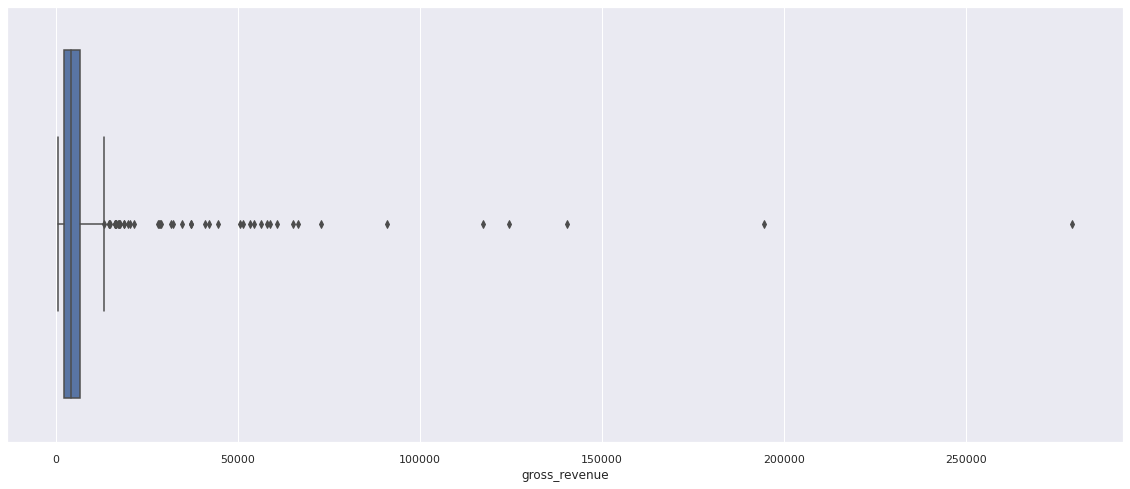

In [187]:
sns.boxplot(df10.loc[df10['cluster']==5, 'gross_revenue'])

<AxesSubplot:xlabel='gross_revenue'>

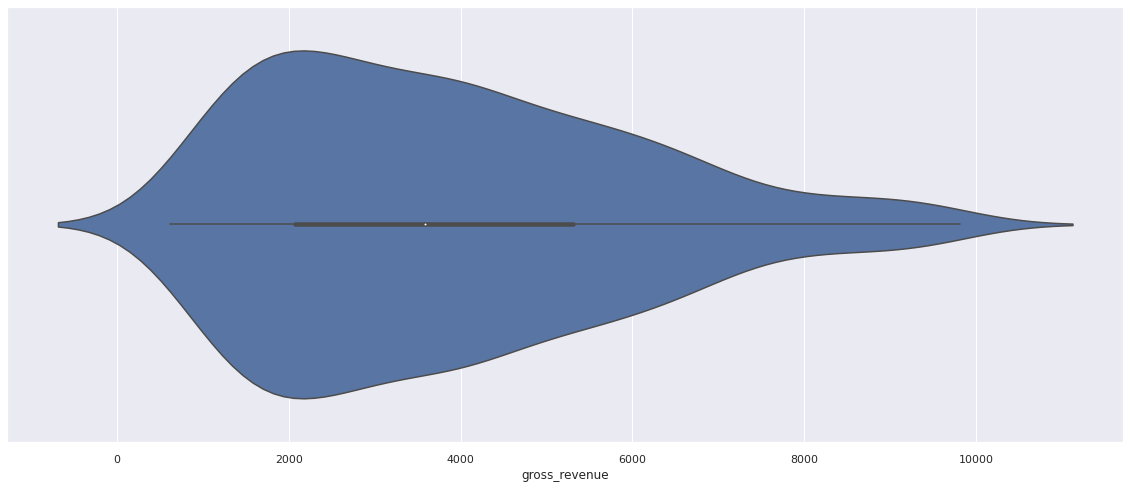

In [188]:
# "Zoom" no boxplot
df_aux = df10.loc[(df10['cluster']==5) & (df10['gross_revenue']<10000), 'gross_revenue']
sns.violinplot(x=df_aux)


### 10.3 Perguntas de Negócios

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
2. Quantos clientes farão parte do grupo?
3. Quais as principais características desses clientes ?
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
7. Quais as condições para uma pessoa ser removida do Insiders ?
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

#### Q1: Quem são as pessoas elegíveis para participar do programa de Insiders ?

In [189]:
df10.loc[df10['cluster']==5, 'customer_id'].head()

0     17850
2     12583
6     14688
8     15311
12    16029
Name: customer_id, dtype: int64

#### Q2: Quantos clientes farão parte do grupo?

In [190]:
df10.loc[df10['cluster']==5, 'customer_id'].size


466

#### Q3: Quais as principais características desses clientes ?

- Avg Revenue: $8,859.36
- Avg Recency: 21 days
- Avg of products purchased: 425 products
- Frequency: 0,09 purchase/day

#### Q4: Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

In [191]:
df_gmv_insiders = df10.loc[df10['cluster'] == 5, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# Insiders rate
print(f'% Gross Revenue Insiders: {df_gmv_insiders / df_gmv_total:.2%}')

% Gross Revenue Insiders: 52.33%


#### Q5: Qual a expectativa de faturamento desse grupo para os próximos meses ?

#### Q6: Quais as condições para uma pessoa ser elegível ao Insiders ?

O modelo irá definir quem está apto a entrar no Insiders

#### Q7: Quais as condições para uma pessoa ser removida do Insiders ?

O modelo irá definir quem vai sair do Insiders

#### Q8: Qual a garantia que o programa Insiders é melhor que o restante da base ?

In [192]:
df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtd_products,frequency,returns
5,5,466,16.804904,8859.361738,21.263948,425.401288,0.088629,145.798283
0,0,160,5.769924,3139.284312,35.556250,172.100000,0.057344,23.287500
4,4,438,15.795168,2657.691986,51.728311,97.152968,0.034104,26.776256
6,6,333,12.008655,2392.535526,42.360360,127.678679,0.037537,15.765766
3,3,466,16.804904,1256.476438,58.459227,57.622318,0.032821,7.753219
2,2,489,17.634331,956.551963,77.198364,33.040900,0.039464,8.701431
1,1,421,15.182113,580.771591,94.370546,14.377672,0.060211,1.111639


#### Q9: Quais ações o time de marketing pode realizar para aumentar o faturamento?

Ações que vão impactar o faturamento:
- Ações de Cross Sell para aumentar a quantidade de produtos comprados
- Açoes promocionais como cupom de desconto para aumentar a frequencia de compra

### 10.6 Quadro de Respostas

# 11. Deploy To Production

### 10.5 Validação das Hipóteses